# Configurations

## Config Variables

In [0]:
# online setting
cameraUrl   = 'http://eeba6d36.ngrok.io';
drive       = 'drive/My Drive/';

# local setting
# drive       = 'E:/CLCs/drive/';
# cameraUrl   = 'http://192.168.0.103:8080/shot.jpg';


videoFile   = drive + 'colab/videos/sample4.mp4'
facesDir    = drive + 'colab/faces/'
videosDir   = drive + 'colab/videos/'
outputFile  = drive + 'colab/output.mp4'

## Dependencies

In [0]:
!pip install dlib face_recognition opencv-python ipdb

# Main Classes

In [0]:
import numpy as np;
import cv2;
import math;
from tqdm.notebook import tqdm;
from time import sleep;
import termcolor;
from ipdb import set_trace;


class VideoStreamBase():

    def __del__(self):
        cv2.destroyAllWindows();

    def getImage(self) -> np.ndarray:
        raise NotImplementedError();

    def displayVideo(self, limit: int = 0, lag: int = 0, display_id: int = 1, width: int = 400, height: int = 200):
        try:
            while(self.displayImage(display_id, width, height)):
                sleep(lag);
        except(KeyboardInterrupt):
            print(termcolor.colored('video stream stopped voluntarily', 'green'));

    def displayImage(self, display_id: int = None, width: int = 400, height: int = 200, img = None) -> bool:
        img = self.getImage() if img is None else img;
        if(img is None): return False;

        img = PIL.Image.fromarray(img, 'RGB')
        buffer = BytesIO()
        img.save(buffer, format="jpeg")
        display(
            IPython.display.Image(
                data=buffer.getvalue(), format='jpeg', width=width, height=height
                ), display_id=display_id);

        return True;
        
    def __len__(self):
        raise NotImplementedError();
    
    def fps(self):
        raise NotImplementedError();

    def download(self, path: str = 'output.mp4', fps: float = None, limit: int = None, display: bool = False,
                 safeMode: bool = True, width: int = None, height: int = None):

        nFrame = len(self) - 1 if limit is None else limit;
        if(nFrame == 0): raise Exception('No Frames Found');

        img = self.getImage();

        if(height is None): height = img.shape[0];
        if(width  is None): width  = img.shape[1];

        fourcc =  cv2.VideoWriter_fourcc(*'XVID');
        fps_ = self.fps() if fps is None else fps;
        outputVideo = cv2.VideoWriter(path, fourcc, fps_, (width, height), 1)
        
        # set_trace();
        with tqdm(total=nFrame) as progressbar:
            currentFrame = 0;
            nextImg = None;
            while(currentFrame < nFrame and img is not None):
                try:
                    if(display): self.displayImage(1, width, height, img);
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
                    nextImg = self.getImage();
                except Exception as e:
                    if(safeMode):
                        print(colored('Exception:', 'red'));
                        print(e);
                    else:
                        raise e;

                outputVideo.write(img);
                currentFrame += 1;
                progressbar.update(1);
                img = nextImg;

        outputVideo.release();

In [0]:
import face_recognition
import os


class FaceDetector(VideoStreamBase):

    video: VideoStreamBase
    
    def __len__(self):
        return len(self.video);

    def fps(self):
        return self.video.fps();

    def __init__(self, video: VideoStreamBase, facesDir: str):
        self.video = video;

        self.known_faces = [];
        self.known_names = [];
        for file in os.listdir(facesDir):
            if(file.endswith('.jpg')): 
                path = os.path.join(facesDir, file);
                name = file[:-4];

                img = face_recognition.load_image_file(path);
                face_encoding = face_recognition.face_encodings(img)[0]

                self.known_faces.append(face_encoding);
                self.known_names.append(name);

    def getImage(self):
        img = self.video.getImage();
        if(img is None): return None;

        face_locations = face_recognition.face_locations(img, model="cnn")
        face_encodings = face_recognition.face_encodings(img, face_locations)

        people = [];
        for face_encoding in face_encodings:
            tolerance = 0.60;
            # match = face_recognition.compare_faces(self.known_faces, face_encoding, tolerance=tolerance)
            match = face_recognition.face_distance(self.known_faces, face_encoding)

            # id = np.argmax(match);
            # name = self.known_names[id] if match[id] else None;

            id = np.argmin(match);
            name = self.known_names[id] if match[id] <= tolerance else None;

            people.append(name);

        for (top, right, bottom, left), name in zip(face_locations, people):
            color = (255, 0, 0) if name is None else (0, 255, 0);
            cv2.rectangle(img, (left, top), (right, bottom), color, 2);

            if(name is None): continue;

            cv2.rectangle(img, (left, bottom - 42), (right, bottom), color, cv2.FILLED)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(img, name, (left + 5, bottom - 8), font, 1.5, (0, 0, 0), 2);

        return img;

# video = FaceDetector(VideoReader(videoFile), facesDir);
# video.download(outputFile, 25);

# Offile Setting

In [0]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from io import BytesIO
import IPython
import PIL


class VideoReader(VideoStreamBase):
    
    def __init__(self, file):
        self.capture = cv2.VideoCapture(file)

    def __del__(self):
        self.capture.release()
        super(VideoReader, self).__del__();

    def __len__(self):
        return int(self.capture.get(cv2.CAP_PROP_FRAME_COUNT));

    def fps(self):
        return self.capture.get(cv2.CAP_PROP_FPS);

    def getImage(self):
        ret, frame = self.capture.read()
        if(ret == False): return None;
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame;

# video = VideoReader(videoFile);
# video.displayImage();

In [0]:
# videoFile = drive + 'colab/videos/sample4.mp4'
# video = FaceDetector(VideoReader(videoFile), facesDir);
# video.download(outputFile);

# Online Setting

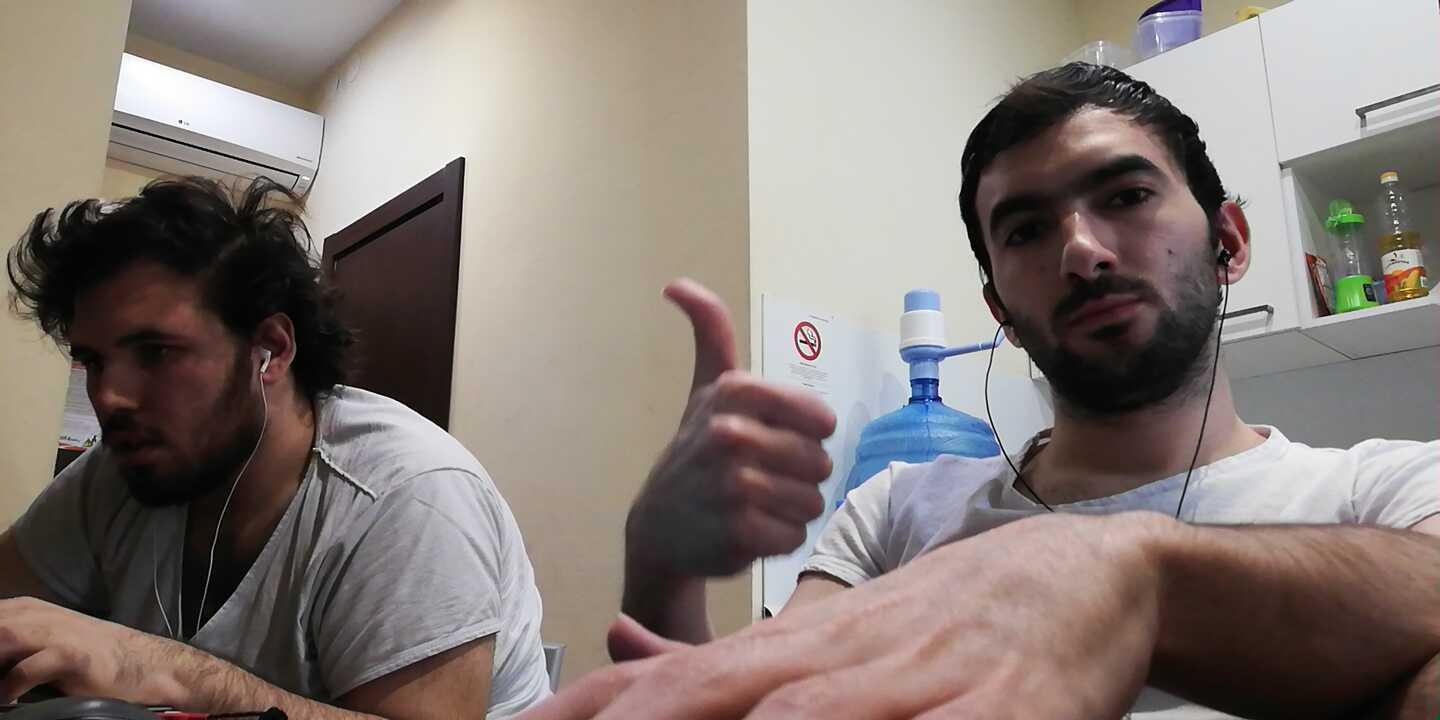

In [0]:
import numpy as np;
import requests;
import cv2;
from time import sleep;

class Camera(VideoStreamBase):

    def __init__(self, url):
        self.url = url;

    def getFrame(self):
        img_resp = requests.get(self.url);
        return img_resp;

    def getImage(self):
        img = self.getFrame();
        img = np.array(bytearray(img.content), dtype=np.uint8);
        
        img = cv2.imdecode(img, cv2.IMREAD_COLOR);
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return img;


# camera = Camera(cameraUrl);
# camera.displayImage();

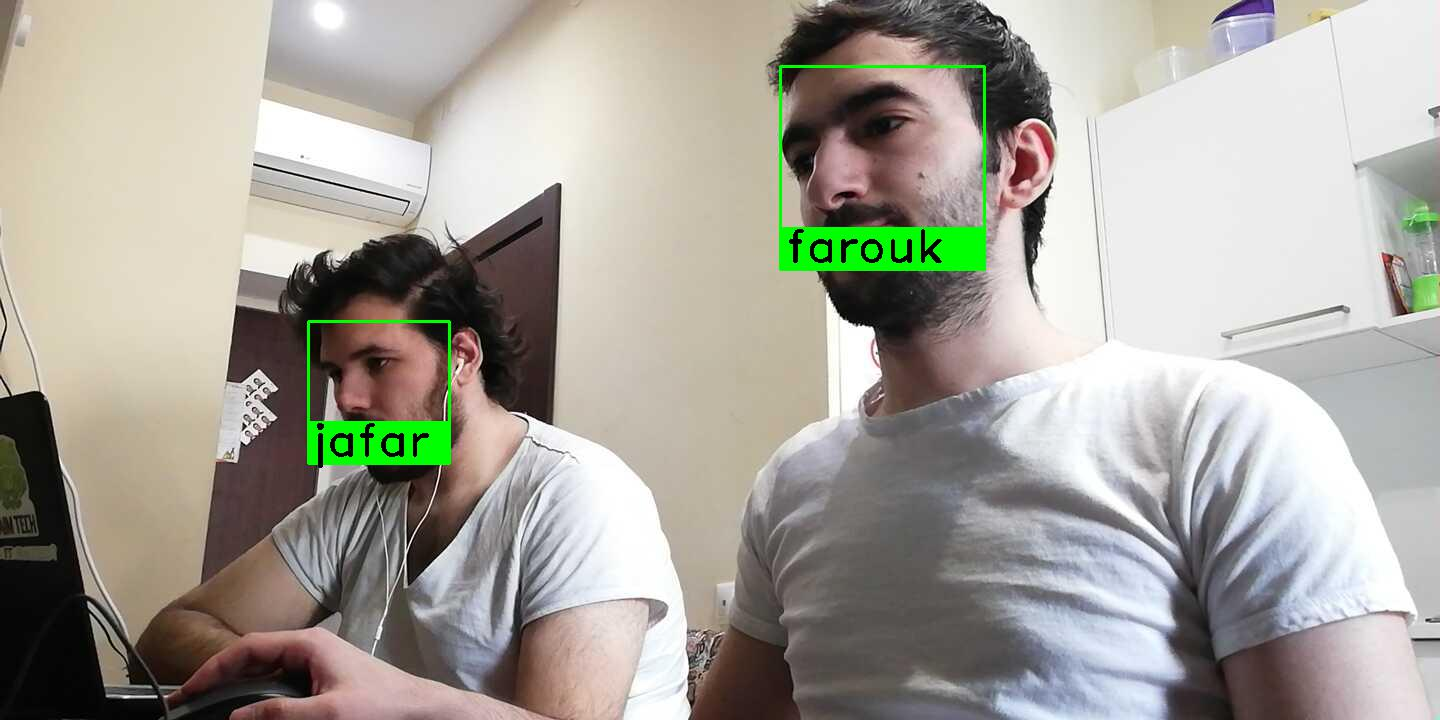

In [0]:
video = FaceDetector(Camera(cameraUrl), facesDir);
video.download(outputFile, fps=10, limit=200, display=True);

# Main Classes for Local Setting

In [0]:
import numpy as np;
import cv2;
import termcolor;


class LocalVideoStream(VideoStreamBase):

    def displayVideo(self, displayName = 'Streaming'):
        while(True):
            img = self.getImage();
            
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR);
            cv2.imshow(displayName, img);

            if(cv2.waitKey(1) & 0xFF == ord('q')): # press `q` to break
                break;
        
        print(termcolor.colored('video stream stopped voluntarily', 'green'));
        print(termcolor.colored('WARNING: object deleted', 'yellow'));
        self.__del__();

In [0]:
class LocalFaceDetector(LocalVideoStream, FaceDetector):
    def __init__(self, video: VideoStreamBase, facesDir: str):
        super(LocalFaceDetector, self).__init__(video, facesDir);

# Laptop Webcam Setting

In [0]:
import numpy as np;
import cv2;


class WebCam(LocalVideoStream):

    def __init__(self, deviceId: int = 0):
        self.capture = cv2.VideoCapture(deviceId);

    def __del__(self):
        self.capture.release();
        super(WebCam, self).__del__();

    def getImage(self):
        ret, img = self.capture.read();
        if(not ret): return None;

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img;

# video = WebCam();
# video.displayVideo();

In [0]:
# video = LocalFaceDetector(WebCam(), facesDir);
# video.displayVideo();

# Local Setting

In [0]:
class LocalCamera(LocalVideoStream, Camera):
    def __init__(self, url: str):
        super(LocalCamera, self).__init__(url);
        
# video = LocalCamera(cameraUrl);
# video.displayVideo();

In [0]:
# video = LocalFaceDetector(LocalCamera(cameraUrl), facesDir);
# video.displayVideo();